### Краткий обзор

DeepFace это обёртка над современныеми моделями для распознования лиц, такими как: VGG-Face, Google FaceNet, OpenFace, Facebook DeepFace, DeepID, Dlib, ArcFace.

Как решается задача Face recognition:

Pipeline состоит из 4 этапов: детекция, выравнивание (если лицо повернуто в бок, выравниваем его), представление (извлечение фич в вектор) и проверка (измерение дистации между векторами). Натренированные модели извлекают вектор с фичами, далее между этими векторами измеряют растояние. Ближайшие друг к другу признаются более похожими.

Для запуска модели DeepFace на GPU желательно иметь не менее [10 Gb](https://github.com/serengil/deepface/issues/36) памяти.

Считать на [GPU](https://github.com/serengil/deepface/issues/164). По дефолту будет использоваться GPU, если она есть.

[Переключение](https://github.com/serengil/deepface/issues/108) между GPU и CPU.

Если хотим переключить вычисления с GPU на CPU, используем данную команду:

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "" # пустые ковычки или "0" если хотим вычислять на GPU с id 0.

In [ ]:
# посмотреть настройки среды
# os.environ

Установим библиотеку DeepFace и обновим cv2, которая используется внутри для предобработки изображений и детекции.

In [1]:
!pip install deepface -q

     |████████████████████████████████| 61kB 4.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3MB 15.7MB/s 


In [2]:
!pip install opencv-python -U

     |████████████████████████████████| 50.4MB 64kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


### Download dataset

Воспользуемся датасетом [Large-scale CelebFaces Attributes (CelebA) Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

Скачаем датасет из [Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset) через API.

После скачивания лучше не смотреть изображения в каталоге на панеле слева, а посмотреть в командной строке linux через !ls. Так как при открытии папки в каталоге из-за большого кол-ва файлов зависает браузер.

In [3]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!sudo chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:38<00:00, 67.5MB/s]
100% 1.33G/1.33G [00:38<00:00, 37.2MB/s]


In [5]:
import os
from zipfile import ZipFile
zip_file = ZipFile('celeba-dataset.zip')
zip_file.extractall()
os.remove('celeba-dataset.zip')

In [ ]:
!du -sh img_align_celeba

1.7G	img_align_celeba


In [ ]:
!ls img_align_celeba/img_align_celeba

Посмотрим, что скачали.

In [6]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

def draw(path):
    img = np.array(Image.open(path))
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.show()

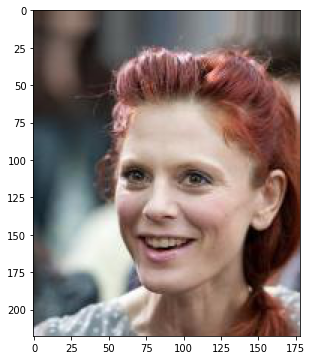

In [7]:
path = 'img_align_celeba/img_align_celeba/000002.jpg'
draw(path)

### Создать тестовое множество

Случайным образом выберем 100 изображений для тестирования.

In [ ]:
# переопределим 100 примеров, в случае, если deepface выдаст ошибку, что не может детектировать лицо в изображении из папки
# !rm -r test

In [8]:
import os
import random
import shutil
import numpy as np

def create_test_dataset(num_example = 100, del_test = False):
  
  if del_test:
    shutil.rmtree('test')
  
  dir = 'img_align_celeba/img_align_celeba/'
  all_paths = [dir + path for path in os.listdir(path = dir)]
  paths = random.sample(all_paths, num_example)
  os.mkdir('test')

  print(f'Тестовый датасет создан. Всего примеров: {num_example}')
  
  for path in paths:
    shutil.copy(path, 'test')
  
  return paths

In [9]:
paths = create_test_dataset()

Тестовый датасет создан. Всего примеров: 100


Посмотрим размер изображений.

In [10]:
for path in paths[:10]:
  print(Image.open(path).size)

(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)


### Обзор характеристик моделей

Доступные модели для задачи Representation (создания вектора фич).

В [данном видео](https://www.youtube.com/watch?v=i_MOwvhbLdI) сравниваются все модели, самая точная оказалась **Facenet**. 

Каждая модель имеет различные размерности входа и выхода:

**DeepFace | Facebook | 2014**

input: (152, 152, 3)

output: 4096

**FaceNet | Google | 2015**

input: (160, 160, 3)

output: 128

**VGGFace | University of Oxford | 2015**

input: (224, 224, 3)

output: 2622


**OpenFace | Carnegie Mellon University | 2016**

input: (96, 96, 3)

output: 128

Данные модели были натренирована для задачи классификации. После чего был удален последний полносвязный слой и выходом моделей стал вектор с фичами.

In [ ]:
#from deepface.basemodels import VGGFace, OpenFace, Facenet, FbDeepFace
#model = VGGFace.loadModel()
#model = Facenet.loadModel()
#model = OpenFace.loadModel()
#model = FbDeepFace.loadModel()

Посмотрим на примере модели VGGFace, размерности входа и выхода.

In [11]:
from deepface import DeepFace
from deepface.basemodels import VGGFace
import pandas as pd

model = VGGFace.loadModel()

Directory  /root /.deepface created
Directory  /root /.deepface/weights created
vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo
To: /root/.deepface/weights/vgg_face_weights.h5
580MB [00:09, 64.3MB/s]


In [ ]:
# можно построить модель так
# from deepface import DeepFace
# model = DeepFace.build_model('VGG-Face')

Посмотрим размерности входного слоя и выходного.

In [ ]:
input_shape = model.layers[0].input_shape[0][1:]
output_shape = model.layers[-1].input_shape[1:]
print('Input shape: ', input_shape, '\nOutput shape: ', output_shape)

Input shape:  (224, 224, 3) 
Output shape:  (1, 1, 2622)


In [ ]:
from deepface.commons import functions

input_shape = functions.find_input_shape(model)
input_shape

(224, 224)

Проэксперементируем. Посмотрим, что отдает модель.

Функция functions.preprocess_face внутри проводит детекцию.

В качестве модели для детекции доступны 4 модели: opencv (по дефолту), ssd, dlib, mtcnn. 

На 09.02.2021 работает только opencv, остальные выдают ошибки.

In [12]:
from deepface.commons import functions
# возьмем произвольное изображение из папки test
img = random.sample(os.listdir(path = 'test'), 1)[0]
path = f'img_align_celeba/img_align_celeba/{img}'
# берет путь к изображению или numpy, если берет путь, то выдает ошибку, поэтому передаем numpy
# детектирует изображение и преобразует данные в нужную размерность
# detector_backend: ['mtcnn', 'opencv', 'ssd', 'dlib']
input = functions.preprocess_face(path, detector_backend = 'opencv', enforce_detection = False)
# получим предсказание
output = model.predict(input)
# видим,что получили вектор shape(1, 2622)
output.shape

(1, 2622)

Визуализируем выход в виде изображения и виде численного вектора. Видим, что получаем детектированное лицо.

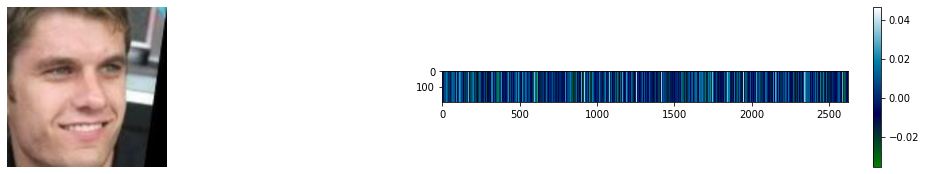

In [ ]:
import matplotlib.pyplot as plt

img_graph = []

# 200 раз добавим данные, на графике это будет высота графика
for i in range(200):
  img_graph.append(output[0, :])

fig = plt.figure(figsize=(20, 10))

# отобразим изображение
ax1 = fig.add_subplot(3, 2, 1)
plt.imshow(input[0][:, :, ::-1])
plt.axis('off')

# отобразим вектор фич
ax2 = fig.add_subplot(3, 2, 2)
im = plt.imshow(img_graph, interpolation = 'nearest', cmap = plt.cm.ocean)
plt.colorbar();

На выходе получаем вектора фич [1x2622].

### Исследуем изображения, которые модель не способна детектировать

Функция из репо, путь для загрузки детектора CascadeClassifier.

In [ ]:
def get_opencv_path():
	opencv_home = cv2.__file__
	folders = opencv_home.split(os.path.sep)[0:-1]
	
	path = folders[0]
	for folder in folders[1:]:
		path = path + "/" + folder
	
	return path+"/data/"

Инициализируем детектор `'opencv'`.

In [ ]:
import cv2

opencv_path = get_opencv_path()
face_detector_path = opencv_path+"haarcascade_frontalface_default.xml"

if os.path.isfile(face_detector_path) != True:
  raise ValueError("Confirm that opencv is installed on your environment! Expected path ",face_detector_path," violated.")

face_detector = cv2.CascadeClassifier(face_detector_path)

face_detector

<CascadeClassifier 0x7f7b7209da10>

Отобразим изображения, которые не детектируются.

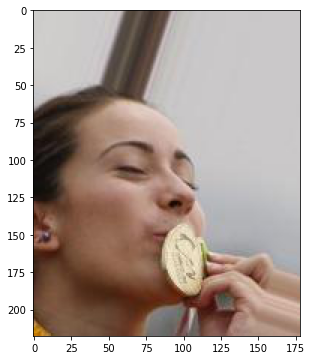

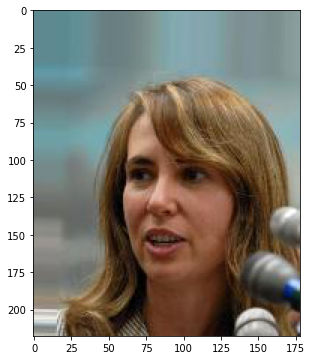

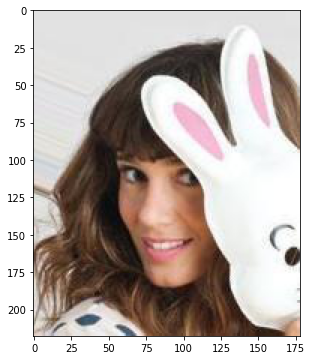

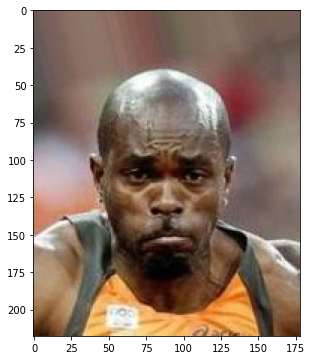

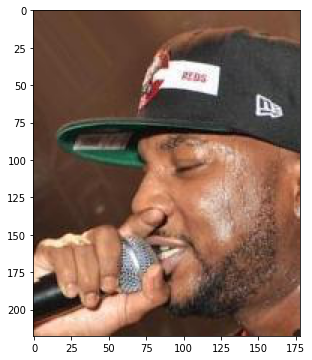

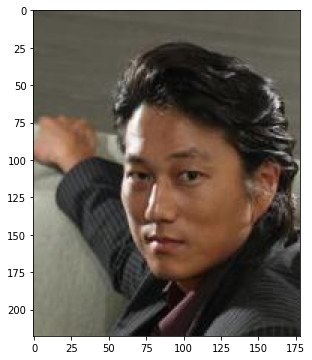

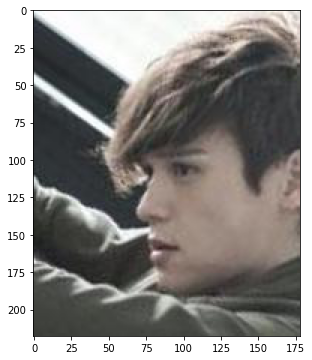

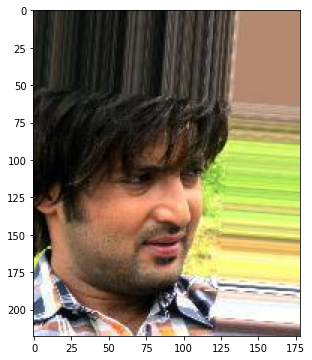

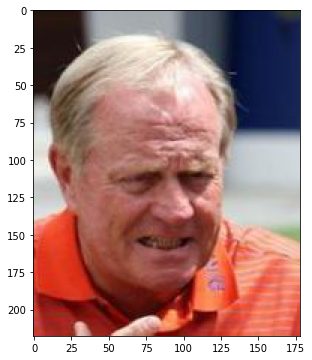

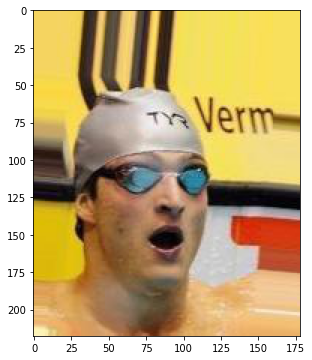

In [ ]:
fail = []
for i, path in enumerate(paths):
  img = cv2.imread(path) # reads in BGR format
  #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR to RGB
  faces = face_detector.detectMultiScale(img, 1.3, 5)
  if len(faces) == 0:
    fail.append((i, path))
    draw(path)

### Сравнение GPU и CPU используя DeepFace.find pipeline

DeepFace.find pipeline включает в себя детекцию, распознование (извлечение векторов фич) и верификацию (вычисление расстояния между векторами).

При первом запуске DeepFace.find() из каждого изображения извлекается вектор фич и сохраняется в матрицу, которая записывается в файл representations_name_model.pkl.

Структура файла representations_name_model.pkl:

[[str, numpy], ..., [str, numpy]].

str: путь к изображению

numpy: вектор фич

При повторном запуске, операция по извелечению фич не происходит, используются уже вычисленные вектора из representations_name_model.pkl.

В DeepFace.find есть важный булев параметр enforce_detection, если True, то мы принуждаем модель детектировать изображение, если детекцию на фотографии нельзя произвести, то вызывается ошибка.

Если False, то в случае, если лицо детектировать не удаёться, дальше для извлечения фич подаётся модели не детектированное лицо, а полное изображение.

[Важное примечание](https://www.youtube.com/watch?v=Hrjp-EStM_s&feature=youtu.be), если мы методу DeepFace.find() явно не укажем используемую модель, то данная модель будет строиться внутри, это занимает некоторое время. Чтобы ускорить инференс, необходимо предварительно построить модель и потом передать её. 

Первоначальное вычисление векторов на GPU.

In [16]:
from deepface import DeepFace
from deepface.basemodels import VGGFace
import pandas as pd

model = VGGFace.loadModel()

img = random.sample(os.listdir(path = 'test'), 1)[0]
# img_path: path or numpy
# db_path: .jpg or .png
df = DeepFace.find(img_path = f'img_align_celeba/img_align_celeba/{img}', db_path = 'test', 
                   model_name = 'VGG-Face', model = model, distance_metric = 'cosine', enforce_detection= False)

Finding representations:   0%|          | 0/100 [00:00<?, ?it/s]

Already built model is passed


Analyzing:   0%|          | 0/1 [00:00<?, ?it/s]

Representations stored in  test / representations_vgg_face.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

find function lasts  94.30981397628784  seconds


Первоначальное вычисление векторов на CPU.

In [ ]:
# отключим gpu
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "" # or "0", чтобы включить gpu

In [ ]:
from deepface import DeepFace
from deepface.basemodels import VGGFace
import pandas as pd

model = VGGFace.loadModel()

img = random.sample(os.listdir(path = 'test'), 1)[0]
# img_path: path or numpy
# db_path: .jpg or .png
df = DeepFace.find(img_path = f'img_align_celeba/img_align_celeba/{img}', db_path = 'test', 
                   model_name = 'VGG-Face', model = model, distance_metric = 'cosine', enforce_detection= False)

Finding representations:   0%|          | 0/100 [00:00<?, ?it/s]

Already built model is passed


Analyzing:   0%|          | 0/1 [00:00<?, ?it/s]

Representations stored in  test / representations_vgg_face.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

find function lasts  99.68821477890015  seconds


При повторном запуске, будут использованы вычисленные вектора representations_name_model.pkl, поэтому инференс происходит моментально.

На GPU.

In [ ]:
img = random.sample(os.listdir(path = 'test'), 1)[0]

df = DeepFace.find(img_path = f'img_align_celeba/img_align_celeba/{img}', db_path = 'test', 
                   model_name = 'VGG-Face', model = model, distance_metric = 'cosine')

Analyzing:   0%|          | 0/1 [00:00<?, ?it/s]

Already built model is passed
There are  100  representations found in  representations_vgg_face.pkl


Analyzing: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

find function lasts  1.3023653030395508  seconds


На CPU.

In [ ]:
img = random.sample(os.listdir(path = 'test'), 1)[0]

df = DeepFace.find(img_path = f'img_align_celeba/img_align_celeba/{img}', db_path = 'test', 
                   model_name = 'VGG-Face', model = model, distance_metric = 'cosine')

Analyzing:   0%|          | 0/1 [00:00<?, ?it/s]

Already built model is passed
There are  100  representations found in  representations_vgg_face.pkl


Analyzing: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

find function lasts  2.217811346054077  seconds


Посмотрим, что на DataFrame, который отдаем нам pipeline DeepFace.find.

Face recognishion имеет линейную сложность алгоритма $O(n)$.

In [ ]:
df

,identity,VGG-Face_cosine
0,test/084255.jpg,0.000000
1,test/170054.jpg,0.325705
2,test/122710.jpg,0.335566
3,test/168663.jpg,0.358672
4,test/158536.jpg,0.364691
5,test/148415.jpg,0.364825
6,test/107497.jpg,0.375732
7,test/139628.jpg,0.379028
8,test/040986.jpg,0.380664
9,test/178599.jpg,0.381957


In [ ]:
# если схожих лиц не будет найдено, вернется пустой массив
# необходима проверка, может ничего не вернуть
if df.shape[0] > 0:
  identity = df.iloc[0].identity

identity

'test/013152.jpg'

Визуализируем выдачу.

In [ ]:
import sys
import math
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from typing import Dict, List, Tuple

def draw_found(source: str, df: 'DataFrame', k: 'num_face' = 1) -> print:

    if df.shape[0] > 0:
      found = df.identity.iloc[:k].to_list()
    else:
      sys.exit('Похожих лиц не найдено.')
    
    if k <= 4:
      nrows = 1
      ncols = k + 1
    else:
      nrows = math.ceil(k / 4)
      ncols = 4

    paths = [source] + found
    titles = ['source'] + ['found' for _ in found]
    model = df.columns[1]
    cos = [9] + df[model].iloc[:k].to_list()

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6), sharey=False, sharex=True)
                        
    for i, (fig_x, path, title, c) in enumerate(zip(ax.flatten(), paths, titles, cos), start = 1):
        image = np.array(Image.open(path))
        fig_x.set_title(title, fontsize=15)
        fig_x.imshow(image)
        if i > 1:
          fig_x.add_patch(patches.Rectangle((0, 0), 86, 35, color='white'))
          font = FontProperties()
          fig_x.text(5, 12, f'cos: {round(c, 3)}', horizontalalignment='left', fontproperties=font,
                      verticalalignment='top',fontsize=8, color='black',fontweight='bold')

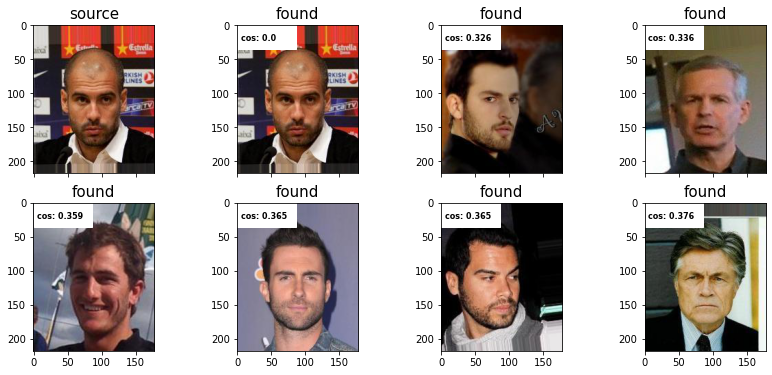

In [ ]:
source = f'img_align_celeba/img_align_celeba/{img}'
draw_found(source, df, 7)

### Инференс на 50000 примерах.

Вычисления векторов для 50К изображений займёт более 10 часов. Мы можем вычислить 100 векторов, сгенерировать pickle файл, после чего скопировать вектора из pickle файла до 50К, и потом его использовать, чтобы посмотреть сколько времени займёт инференс!

Сгенерируем файл pikl. откроем его и скопируем данные, дальше подадим на инференс модели и замерим скорость.

In [ ]:
from deepface import DeepFace
from deepface.basemodels import Facenet
import pandas as pd

model = Facenet.loadModel()

img = random.sample(os.listdir(path = 'test'), 1)[0]
# img_path: path or numpy
# db_path: .jpg or .png
df = DeepFace.find(img_path = f'img_align_celeba/img_align_celeba/{img}', db_path = 'test', 
                   model_name = 'Facenet', model = model, distance_metric = 'cosine'б enforce_detection = False)



Finding representations:   0%|          | 0/100 [00:00<?, ?it/s]

Already built model is passed




Finding representations:   1%|          | 1/100 [00:03<05:20,  3.23s/it]

Finding representations:   2%|▏         | 2/100 [00:04<04:05,  2.50s/it]

Finding representations:   3%|▎         | 3/100 [00:04<03:12,  1.98s/it]

Finding representations:   4%|▍         | 4/100 [00:06<02:51,  1.78s/it]

Finding representations:   5%|▌         | 5/100 [00:06<02:20,  1.48s/it]

Finding representations:   6%|▌         | 6/100 [00:07<02:01,  1.29s/it]

Finding representations:   7%|▋         | 7/100 [00:08<01:47,  1.16s/it]

Finding representations:   8%|▊         | 8/100 [00:09<01:37,  1.05s/it]

Finding representations:   9%|▉         | 9/100 [00:10<01:29,  1.02it/s]

Finding representations:  10%|█         | 10/100 [00:11<01:24,  1.07it/s]

Finding representations:  11%|█         | 11/100 [00:11<01:20,  1.11it/s]

Finding representations:  12%|█▏        | 12/100 [00:12<01:19,  1.10it/s]

Finding representations:  13%|█▎        | 13/100 [00:13<01:17,  1.12it/s]

Finding representations:  14%|█▍

Representations stored in  test / representations_facenet.pkl  file. Please delete this file when you add new identities in your database.




Analyzing: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

find function lasts  86.5336389541626  seconds


Посмотрим структуру pickle файла. 

In [ ]:
import pickle

with open('test/representations_facenet.pkl', 'rb') as f:
  data = pickle.load(f)

In [ ]:
type(data), len(data)

(list, 100)

In [ ]:
# [[str, numpy], ..., [str, numpy]]
data[0]

['test/050325.jpg',
 array([-0.28490156,  1.2472281 , -0.09354122, -0.3031467 ,  2.0662494 ,
        -1.1031195 ,  1.5379909 ,  0.4481754 ,  0.2516297 ,  0.11629355,
        -1.4371425 , -1.8972063 ,  0.05082469,  1.3012831 ,  1.7136091 ,
        -0.18542351, -0.38624895, -2.3863213 , -1.7043718 , -2.1460752 ,
        -0.775244  , -1.2474097 ,  1.8273374 ,  1.5626726 , -1.4160923 ,
         1.5355973 ,  2.2967384 , -1.6190944 ,  1.3236154 ,  1.4777359 ,
        -0.9464054 , -1.9901563 ,  1.7841997 , -0.996794  ,  0.27017057,
         0.86940086, -0.30106285, -0.16437262,  0.48304036,  0.24856047,
        -0.39683318, -1.4875172 , -0.2668022 , -0.02364662, -0.12019914,
         0.45013532, -0.15155809, -1.2201533 , -0.78494805, -1.72501   ,
         0.5295422 ,  0.3807759 , -0.51018447, -0.18350568, -0.6145022 ,
         0.37017593, -0.0931756 , -0.7781002 ,  2.8143153 ,  1.1509447 ,
        -1.9367906 , -0.989479  ,  0.6716771 , -1.6026951 , -1.3989075 ,
        -0.8419414 , -2.2985659

Скопируем каждый пример по 500 раз, получим 50000 примеров.

In [ ]:
%%time
new_data = [exaple for exaple in data for _ in range(500)]

CPU times: user 3.42 ms, sys: 55 µs, total: 3.48 ms
Wall time: 3.5 ms


In [ ]:
len(new_data)

50000

In [ ]:
%%time
with open('test/representations_facenet.pkl', 'wb') as f:
  pickle.dump(new_data, f) #256 kb

CPU times: user 5.06 ms, sys: 5 µs, total: 5.07 ms
Wall time: 7.29 ms


Запустим инференс, в котором будет использоваться наш pickle файл с 50000 примерами.

In [ ]:
from deepface import DeepFace
from deepface.basemodels import Facenet
import pandas as pd

model = Facenet.loadModel()

img = random.sample(os.listdir(path = 'test'), 1)[0]
# img_path: path or numpy
# db_path: .jpg or .png
df = DeepFace.find(img_path = f'img_align_celeba/img_align_celeba/{img}', db_path = 'test', 
                   model_name = 'Facenet', model = model, distance_metric = 'cosine', enforce_detection = False)



Analyzing:   0%|          | 0/1 [00:00<?, ?it/s]

Already built model is passed
There are  50000  representations found in  representations_facenet.pkl




Analyzing: 100%|██████████| 1/1 [00:13<00:00, 13.03s/it]

find function lasts  13.371716499328613  seconds


Посмотрим, какие схожие изображения нашла модель, ожидаем увидеть одинаковые изображения, т.к. было копирование примеров.

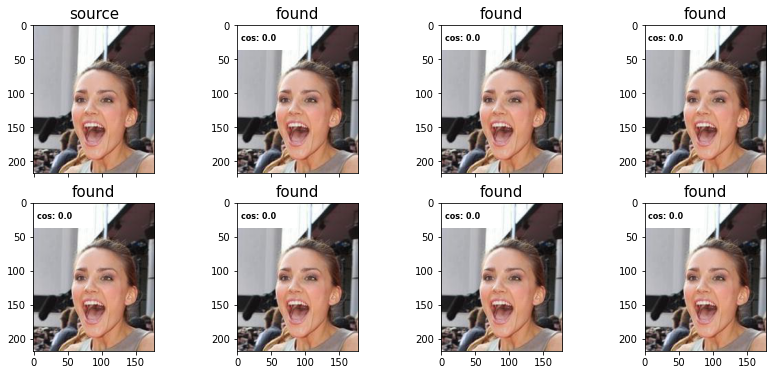

In [ ]:
source = f'img_align_celeba/img_align_celeba/{img}'
draw_found(source, df, 7)

Посмотрим, есть ли Анджелина Джоли в нашем датасете?

In [ ]:
!wget https://temperaturka.com/wp-content/uploads/0/4/2/042d330cba34c2db0f6af74b63a07ea5.jpg -O jolie.jpg

--2021-02-10 16:51:17--  https://temperaturka.com/wp-content/uploads/0/4/2/042d330cba34c2db0f6af74b63a07ea5.jpg
Resolving temperaturka.com (temperaturka.com)... 62.171.166.40
Connecting to temperaturka.com (temperaturka.com)|62.171.166.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67174 (66K) [image/jpeg]
Saving to: ‘jolie.jpg’

jolie.jpg           100%[===================>]  65.60K  --.-KB/s    in 0.02s   

2021-02-10 16:51:17 (3.41 MB/s) - ‘jolie.jpg’ saved [67174/67174]



In [ ]:
df = DeepFace.find(img_path = 'jolie.jpg', db_path = 'test', 
                   model_name = 'Facenet', model = model, distance_metric = 'cosine')



Analyzing:   0%|          | 0/1 [00:00<?, ?it/s]

Already built model is passed
There are  50000  representations found in  representations_facenet.pkl




Analyzing: 100%|██████████| 1/1 [00:11<00:00, 11.98s/it]

find function lasts  12.327686309814453  seconds


In [ ]:
draw_found('jolie.jpg', df, 7)

SystemExit: ignored

### Database solution.

Идея заключается в том, чтобы с помощью модели извлеч вектор фич, записать их в базу, а далее производить вычисление дистанции между векторами.

Построим решение на [SQLite](https://sefiks.com/2021/02/06/deep-face-recognition-with-sql/). Хорошее [объяснение](https://www.youtube.com/watch?v=-pR2hEQubxg) работы с модулем sqlite3.

Руководство по [sqlite3](https://pythonru.com/biblioteki/poluchenie-dannyh-iz-tablicy-sqlite).

Ноутбук с [примером](https://github.com/serengil/tensorflow-101/blob/master/python/Face-Recognition-SQL.ipynb).

Решения:

[Hadoop/Spark](https://sefiks.com/2021/01/31/deep-face-recognition-with-hadoop-and-spark/), [Casandra](https://sefiks.com/2021/01/24/deep-face-recognition-with-cassandra/), [MongoDB](https://sefiks.com/2021/01/22/deep-face-recognition-with-mongodb/).

In [ ]:
import cv2
cv2.__version__

'4.5.1'

In [17]:
from PIL import Image 

from tqdm.notebook import tqdm
from deepface import DeepFace
from deepface.basemodels import Facenet
from deepface.commons import functions
import pandas as pd

model = Facenet.loadModel()
 
instances = []
for i in tqdm(range(len(paths))):
    path = paths[i]

    input_shape = functions.find_input_shape(model)

    #detect and align
    facial_img = functions.preprocess_face(path,
                                           target_size = input_shape,
                                           detector_backend = 'opencv',
                                           enforce_detection = False)
     
    #represent
    embedding = model.predict(facial_img)[0]
     
    #store
    instance = []
    instance.append(path)
    instance.append(embedding)
    instances.append(instance)
 
df = pd.DataFrame(instances, columns = ['img_name', 'embedding'])

facenet_weights.h5 will be downloaded...


Downloading...
From: https://drive.google.com/uc?id=1971Xk5RwedbudGgTIrGAL4F7Aifu7id1
To: /root/.deepface/weights/facenet_weights.h5
92.2MB [00:01, 90.8MB/s]


In [18]:
df.head()

,img_name,embedding
0,img_align_celeba/img_align_celeba/082248.jpg,"[-1.0927919, -0.7208154, -0.8643149, -0.300317..."
1,img_align_celeba/img_align_celeba/110985.jpg,"[-0.31741157, -0.63208187, -0.20021252, 0.7177..."
2,img_align_celeba/img_align_celeba/044502.jpg,"[-1.0466878, -0.22323559, -0.43087238, -0.3487..."
3,img_align_celeba/img_align_celeba/000214.jpg,"[-0.79990053, 0.28331682, -0.2616145, -0.62506..."
4,img_align_celeba/img_align_celeba/071584.jpg,"[0.18236513, -0.16220948, 0.1676635, -0.498573..."


In [ ]:
sqlite3.version

'2.6.0'

In [19]:
import sqlite3

# конектимся к базе данных db, если db нет, будет создана автоматически
conn = sqlite3.connect('facialdb.db')
# позволяет взаимодействовать с db и выполнять какие-либо операции в ней
cursor = conn.cursor()
# создадим таблицу в которой
# (<название столбца> <тип данных>, <название столбца> <тип данных>)
# запишем бинарные файлы
cursor.execute('CREATE TABLE face_meta (ID INT PRIMARY KEY, IMG_NAME VARCHAR(10), EMBEDDING BLOB)')
# запишем вектора
cursor.execute('CREATE TABLE face_embeddings (FACE_ID INT, DIMENSION INT, VALUE DECIMAL(5, 30))')


In [20]:
for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
    img_name = instance['img_name']
    embeddings = instance['embedding']
     
    # SQL запрос, символ ? означает места, куда необходимо вставить переданные переменные
    insert_statement = 'INSERT INTO face_meta (ID, IMG_NAME, EMBEDDING) VALUES (?, ?, ?)'
    # кортеж с переменными которые будем вставлять на место ?
    insert_args = (index, img_name, embeddings.tobytes())
    # выполним SQL запрос
    cursor.execute(insert_statement, insert_args)
    # возьмем каждое значение вектора и запишем в строчку  
    for i, embedding in enumerate(embeddings):
        insert_statement = 'INSERT INTO face_embeddings (FACE_ID, DIMENSION, VALUE) VALUES (?, ?, ?)'
        insert_args = (index, i, str(embedding))
        cursor.execute(insert_statement, insert_args)
# сохраним все изменения в базе
conn.commit()

Запросить все данные из таблицы `fase_embeddings`.

In [21]:
select_query = 'SELECT * from face_embeddings'
cursor.execute(select_query)
records = cursor.fetchall()
records

[(0, 0, -1.0927919),
 (0, 1, -0.7208154),
 (0, 2, -0.8643149),
 (0, 3, -0.30031747),
 (0, 4, -1.0596545),
 (0, 5, 0.24372905),
 (0, 6, -0.6274053),
 (0, 7, -0.45812953),
 (0, 8, -0.25831893),
 (0, 9, -0.171132),
 (0, 10, 0.7476951),
 (0, 11, 0.025317198),
 (0, 12, 0.9723789),
 (0, 13, -0.9669603),
 (0, 14, -0.42627993),
 (0, 15, 0.6671617),
 (0, 16, 1.6289214),
 (0, 17, -1.1129143),
 (0, 18, -1.1932399),
 (0, 19, -0.33126405),
 (0, 20, 0.7286142),
 (0, 21, -0.9760235),
 (0, 22, -0.09472779),
 (0, 23, -0.87962574),
 (0, 24, -0.045469083),
 (0, 25, -0.6490878),
 (0, 26, 0.38386646),
 (0, 27, 0.6591974),
 (0, 28, -0.45722532),
 (0, 29, 0.18657988),
 (0, 30, -1.1134319),
 (0, 31, 0.5024946),
 (0, 32, 0.015006068),
 (0, 33, 0.60793126),
 (0, 34, 0.4692629),
 (0, 35, -0.08101095),
 (0, 36, 1.2156388),
 (0, 37, -0.18946174),
 (0, 38, 0.46087968),
 (0, 39, -0.34331354),
 (0, 40, 0.6663832),
 (0, 41, 0.8254114),
 (0, 42, -0.20586228),
 (0, 43, -0.005045995),
 (0, 44, -0.29935694),
 (0, 45, -1.2

Посмотреть заголовки таблицы.

In [ ]:
titles_tab = [description[0] for description in cursor.description]
titles_tab

['FACE_ID', 'DIMENSION', 'VALUE']

Запросить все данные из таблицы `fase_meta`.

In [ ]:
select_query = 'SELECT * from face_meta'
cursor.execute(select_query)
records = cursor.fetchall()
records

[(0,
  'img_align_celeba/img_align_celeba/169904.jpg',
  b'F\x8c:\xbe\xfes\x10\xbf\xee\x0b\xaf\xbd:\x8a\x8c\xbf\x9b\xc2Q>\xbd\x8e\xa9?Y\xce\x03\xbf\xd6\x92\xdd\xbd\xefA\xff>\xd0Q\xb7>\xe6\xa9\x07>]\xae0\xbfct\x7f>v\xc4\xc7\xbe^\x92.?\x11\x15/?\n\x94k=6n\x86=\xf4\xb8\xc0>\xb9\xe9\xc0\xbe\xb6:c?\xe4.\xca\xbcb\xfb\x06?0\x80"?;hA>\x1e\xd5\x0c\xbf\xe1\x15.\xbe2\x0f.\xbd6*\xfe\xbe\x12\x11\x05?\x07\xf9\xc8\xbe\xdd\xb4\x1c?\xf8\xae\xb1=\xaaJ\xde>#\xcdo?\xf2\xa0\t\xbf{z\xdc\xbe\xef\x99r\xbf(lI>7\xf1u>\x8a@\xe1<q\xffK\xbfJ\x98\x87>%\xcd\xca\xbe`\x85\xed\xbd\xb6\x9ce\xbf\xe7W:>\xd2\xfc\xeb\xbeP\x19L?2O\x02\xbd4\xee2\xbf\x80\xdc\xb6\xbe\x92\x1f\x8f\xbe\xf2\x00\xa0\xbd&\xcdT\xbe#yh\xbf\x9a~\xf5\xbd \x81s\xbf\xa1\xa1\x89\xbf9\xaf\xfa>\x99\xe7\xb8>\xee\x14\xbb\xbe\x91\x18F?\x89\xbf\xb4>p\x8a\x04>\x95c\x08\xbf\xa8\xfa<?\xb0{|?\xc5B\x19?\xe2\xac\xe1\xbcv\xfe\x8a=\xfe\xb7\x9a>\x810\xaf=\x9e\x8f\x1d\xbfd=\x8e?\xa97\xff\xbe\x10$\x0f?\x96\xc6\x18\xbea\xc2\xb5\xbe\x02\x07\xa3>\x96\n\xf0\xbe\xd0\xb2\xc6\xbd\

Посмотреть заголовки таблицы.

In [ ]:
titles_tab = [description[0] for description in cursor.description]
titles_tab

['ID', 'IMG_NAME', 'EMBEDDING']

Построение поиска.

In [23]:
target_img_path = paths[7]
target_img = functions.preprocess_face(target_img_path,
                                       target_size = (160, 160),
                                       enforce_detection = False)

target_embedding = model.predict(target_img)[0].tolist()

In [24]:
target_statement = ""
for i, value in enumerate(target_embedding):
    target_statement += "select %d as dimension, %s as value" % (i, str(value)) #sqlite
    #target_statement += "select %d as dimension, %s as value from dual" % (i, str(value)) #oracle
    
    if i < len(target_embedding) - 1:
        target_statement += " union all "

In [25]:
target_statement

'select 0 as dimension, -0.3214275538921356 as value union all select 1 as dimension, -0.06929753720760345 as value union all select 2 as dimension, -1.1501284837722778 as value union all select 3 as dimension, -0.6874043345451355 as value union all select 4 as dimension, -0.6789187788963318 as value union all select 5 as dimension, -0.12724189460277557 as value union all select 6 as dimension, 0.10884879529476166 as value union all select 7 as dimension, 0.1370026022195816 as value union all select 8 as dimension, -0.5081425905227661 as value union all select 9 as dimension, 0.11229279637336731 as value union all select 10 as dimension, 0.6620355248451233 as value union all select 11 as dimension, -0.335457444190979 as value union all select 12 as dimension, 1.3765758275985718 as value union all select 13 as dimension, -1.0728213787078857 as value union all select 14 as dimension, 0.665725588798523 as value union all select 15 as dimension, 1.4184927940368652 as value union all select

Будем вычислять Эвклидово расстояние.

$distance = \sqrt{ \sum\limits_{i=1}^d (src_i - trg_i)^2 }$

где

$d$ размерность вектора.

$src_i$ это $i$-й элемент вектора из базы.

$trg_i$ это $i$-й элемент target вектора.

In [26]:
select_statement = f"""
    select * 
    from (
        select img_name, sum(subtract_dims) as distance_squared
        from (
            select img_name, (source - target) * (source - target) as subtract_dims
            from (
                select meta.img_name, emb.value as source, target.value as target
                from face_meta meta left join face_embeddings emb
                on meta.id = emb.face_id
                left join (
                    {target_statement}  
                ) target
                on emb.dimension = target.dimension
            )
        )
        group by img_name
    )
    where distance_squared < 100
    order by distance_squared asc
"""

Посмотрим, что выдает SQL запрос.

А возвращает путь к изображению и расстояние до target вектора, без операции извлечения корня. т.е. дистанция сейчас равна:

$distance = \sum\limits_{i=1}^d (src_i - trg_i)^2 $

а корень мы будем извлекать позже.

In [ ]:
cursor.execute(select_statement)
records = cursor.fetchall()
records

[('img_align_celeba/img_align_celeba/184724.jpg', 4.655861615358211e-14),
 ('img_align_celeba/img_align_celeba/074838.jpg', 65.9404710671169),
 ('img_align_celeba/img_align_celeba/110437.jpg', 67.44660213051968),
 ('img_align_celeba/img_align_celeba/026579.jpg', 69.53593055527503),
 ('img_align_celeba/img_align_celeba/061981.jpg', 70.00720716723973),
 ('img_align_celeba/img_align_celeba/019642.jpg', 71.79483194707436),
 ('img_align_celeba/img_align_celeba/153102.jpg', 74.00625686544379),
 ('img_align_celeba/img_align_celeba/091932.jpg', 74.03389956278244),
 ('img_align_celeba/img_align_celeba/133358.jpg', 74.61032503890634),
 ('img_align_celeba/img_align_celeba/116283.jpg', 74.61949579738801),
 ('img_align_celeba/img_align_celeba/090755.jpg', 75.1508341136224),
 ('img_align_celeba/img_align_celeba/026817.jpg', 78.70277083988522),
 ('img_align_celeba/img_align_celeba/159304.jpg', 78.99896207666129),
 ('img_align_celeba/img_align_celeba/144333.jpg', 79.81240664414074),
 ('img_align_celeb

### Разберем SQL запрос вычисления дистанции

Создаст таблицу, с путем к изображению, значением $n$-го элемента вектора из базы, значением $n$-го элеменга target вектора.

Т.е. идёт поэлементное сопоставление векторов из базы с вектором target.

In [ ]:
select_query = f"""select meta.img_name, emb.value as source, target.value as target
                   from face_meta meta
                   left join face_embeddings emb
                   on meta.id = emb.face_id
                   left join ({target_statement}) target
                   on emb.dimension = target.dimension"""

cursor.execute(select_query)
records = cursor.fetchall()
records[126:130]

[('img_align_celeba/img_align_celeba/169904.jpg',
  0.45604396,
  1.1219755411148071),
 ('img_align_celeba/img_align_celeba/169904.jpg',
  1.2040813,
  1.187537431716919),
 ('img_align_celeba/img_align_celeba/021120.jpg',
  -0.2729206,
  -0.9428898096084595),
 ('img_align_celeba/img_align_celeba/021120.jpg',
  -1.0652083,
  0.017480187118053436)]

Видим, что была создана таблица, где каждому элементу из target вектора, был сопоставлен элемент из вектора в базе.


In [ ]:
print('Первый элемент вектора target:', target_embedding[0])
print('Первый элемент первого вектора в базе:', records[0][2])

Первый элемент вектора target: -0.9428898096084595
Строчка из сформированной таблицы: -0.9428898096084595


Выполним операцию $(soutre - target)^2$

In [ ]:
(0.45604396 - 1.1219755411148071)**2

0.44346487072606694

In [ ]:
select_query = f"""select img_name, (source - target) * (source - target) as subtract_dims
                    from (select meta.img_name, emb.value as source, target.value as target
                          from face_meta meta
                          left join face_embeddings emb
                          on meta.id = emb.face_id
                          left join ({target_statement}) target
                          on emb.dimension = target.dimension)"""

cursor.execute(select_query)
records = cursor.fetchall()
records[126:130]

[('img_align_celeba/img_align_celeba/169904.jpg', 0.44346487072606694),
 ('img_align_celeba/img_align_celeba/169904.jpg', 0.0002736995777679323),
 ('img_align_celeba/img_align_celeba/021120.jpg', 0.448858741823384),
 ('img_align_celeba/img_align_celeba/021120.jpg', 1.1722143601379795)]

Сгруппируем по img_namt и суммируем по каждому примеру.

$distance = \sum\limits_{i=1}^d (src_i - trg_i)^2 $

In [ ]:
select_query = f"""select img_name, sum(subtract_dims) as distance_squared
                    from (
                          select img_name, (source - target) * (source - target) as subtract_dims
                          from (
                                select meta.img_name, emb.value as source, target.value as target
                                from face_meta meta left join face_embeddings emb
                                on meta.id = emb.face_id
                                left join ({target_statement}) target
                                on emb.dimension = target.dimension
                                )
                          ) group by img_name"""

cursor.execute(select_query)
records = cursor.fetchall()
records

[('img_align_celeba/img_align_celeba/001575.jpg', 96.78596055811401),
 ('img_align_celeba/img_align_celeba/006697.jpg', 82.09765229901318),
 ('img_align_celeba/img_align_celeba/007467.jpg', 111.31613177829189),
 ('img_align_celeba/img_align_celeba/008173.jpg', 97.33168270873651),
 ('img_align_celeba/img_align_celeba/011923.jpg', 100.19714379459364),
 ('img_align_celeba/img_align_celeba/014712.jpg', 85.34759459476125),
 ('img_align_celeba/img_align_celeba/018401.jpg', 140.1750468570771),
 ('img_align_celeba/img_align_celeba/019642.jpg', 71.79483194707436),
 ('img_align_celeba/img_align_celeba/021120.jpg', 133.56520692727733),
 ('img_align_celeba/img_align_celeba/022708.jpg', 112.56680210957397),
 ('img_align_celeba/img_align_celeba/023935.jpg', 110.59018004851559),
 ('img_align_celeba/img_align_celeba/025591.jpg', 155.34759164330313),
 ('img_align_celeba/img_align_celeba/026579.jpg', 69.53593055527503),
 ('img_align_celeba/img_align_celeba/026817.jpg', 78.70277083988522),
 ('img_align_c

В конце мы ставим условие WHERE, чтобы отображать примеры, где расстояние < 100.

Возьмем корень от расстояния и сформируем список [[path, distance], ..., [path, distance]].

In [ ]:
import time

tic = time.time()
results = cursor.execute(select_statement)

instances = []
for result in results:
    img_name = result[0]
    distance_squared = result[1]
    
    instance = []
    instance.append(img_name)
    instance.append(math.sqrt(distance_squared))
    instances.append(instance)

toc = time.time()
print(toc-tic,"seconds")

img_align_celeba/img_align_celeba/184724.jpg
img_align_celeba/img_align_celeba/074838.jpg
img_align_celeba/img_align_celeba/110437.jpg
img_align_celeba/img_align_celeba/026579.jpg
img_align_celeba/img_align_celeba/061981.jpg
img_align_celeba/img_align_celeba/019642.jpg
img_align_celeba/img_align_celeba/153102.jpg
img_align_celeba/img_align_celeba/091932.jpg
img_align_celeba/img_align_celeba/133358.jpg
img_align_celeba/img_align_celeba/116283.jpg
img_align_celeba/img_align_celeba/090755.jpg
img_align_celeba/img_align_celeba/026817.jpg
img_align_celeba/img_align_celeba/159304.jpg
img_align_celeba/img_align_celeba/144333.jpg
img_align_celeba/img_align_celeba/043374.jpg
img_align_celeba/img_align_celeba/149705.jpg
img_align_celeba/img_align_celeba/186304.jpg
img_align_celeba/img_align_celeba/006697.jpg
img_align_celeba/img_align_celeba/111960.jpg
img_align_celeba/img_align_celeba/014712.jpg
img_align_celeba/img_align_celeba/141140.jpg
img_align_celeba/img_align_celeba/084255.jpg
img_align_

In [ ]:
result_df = pd.DataFrame(instances, columns = ["img_name", "distance"])
result_df

,img_name,distance
0,img_align_celeba/img_align_celeba/184724.jpg,2.157745e-07
1,img_align_celeba/img_align_celeba/074838.jpg,8.120374e+00
2,img_align_celeba/img_align_celeba/110437.jpg,8.212588e+00
3,img_align_celeba/img_align_celeba/026579.jpg,8.338821e+00
4,img_align_celeba/img_align_celeba/061981.jpg,8.367031e+00
5,img_align_celeba/img_align_celeba/019642.jpg,8.473183e+00
6,img_align_celeba/img_align_celeba/153102.jpg,8.602689e+00
7,img_align_celeba/img_align_celeba/091932.jpg,8.604295e+00
8,img_align_celeba/img_align_celeba/133358.jpg,8.637727e+00
9,img_align_celeba/img_align_celeba/116283.jpg,8.638258e+00


### Pipeline SQL

In [28]:
import time
import math

tic = time.time()

target_img_path = paths[7]
target_img = functions.preprocess_face(target_img_path,
                                       target_size = (160, 160),
                                       enforce_detection = False)

target_embedding = model.predict(target_img)[0].tolist()

target_statement = ""
for i, value in enumerate(target_embedding):
    target_statement += "select %d as dimension, %s as value" % (i, str(value)) #sqlite
    #target_statement += "select %d as dimension, %s as value from dual" % (i, str(value)) #oracle
    
    if i < len(target_embedding) - 1:
        target_statement += " union all "

select_statement = f"""
    select * 
    from (
        select img_name, sum(subtract_dims) as distance_squared
        from (
            select img_name, (source - target) * (source - target) as subtract_dims
            from (
                select meta.img_name, emb.value as source, target.value as target
                from face_meta meta left join face_embeddings emb
                on meta.id = emb.face_id
                left join (
                    {target_statement}  
                ) target
                on emb.dimension = target.dimension
            )
        )
        group by img_name
    )
    where distance_squared < 100
    order by distance_squared asc
"""

results = cursor.execute(select_statement)

instances = []
for result in results:
    img_name = result[0]
    distance_squared = result[1]
    
    instance = []
    instance.append(img_name)
    instance.append(math.sqrt(distance_squared))
    instances.append(instance)

toc = time.time()
print(toc-tic,"seconds")

0.20867156982421875 seconds


Посмотрим, правильно ли отработал. Должен найти сам себя.

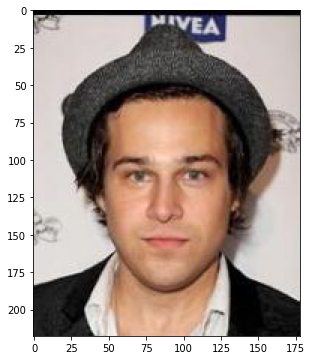

In [29]:
source = target_img_path
target = instances[0][0]
draw(source)

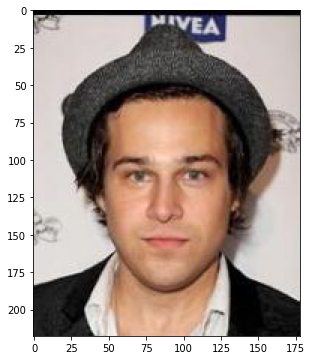

In [30]:
draw(target)

### Таблица сравнений на 100 шт.

In [31]:
pd.DataFrame({'pipeline': ['deepface_gpu', 'deepface_cpu', 'sqlite'],
              'time': ['1.3 sec', '2.2 sec', '0.15 sec']})

,pipeline,time
0,deepface_gpu,1.3 sec
1,deepface_cpu,2.2 sec
2,sqlite,0.15 sec


Datasets:

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

http://web.archive.org/web/20180218212120/http://www.msceleb.org/download/sampleset

### Дополнительные материалы

Обзор задачи Face recognition: https://sefiks.com/2020/05/01/a-gentle-introduction-to-face-recognition-in-deep-learning/

DeepFace threshold: https://sefiks.com/2020/05/22/fine-tuning-the-threshold-in-face-recognition/

Сравнение моделей для recognition: https://www.youtube.com/watch?v=i_MOwvhbLdI

Elasticksearch: https://zen.yandex.ru/media/id/5bbcbc1ba5bd5400a990e7d9/elasticsearch--instrument-dlia-sbora-i-analiza-dannyh-srednego-obema-5f20308b67a6ba5f588075ef

Confluence: https://mind-set.atlassian.net/wiki/spaces/MIN/pages/548864003/Faces+recognition+task

Deepface: https://github.com/serengil/deepface

FaceNet: https://neurohive.io/ru/tutorial/raspoznavanie-lica-facenet/

Ищем знакомые лица: https://habr.com/ru/post/317798/

Introduction to Facenet: https://medium.com/analytics-vidhya/introduction-to-facenet-a-unified-embedding-for-face-recognition-and-clustering-dbdac8e6f02

FaceNet with memory: https://medium.com/asap-report/facenet-with-memory-vs-synthetic-faces-8e87a009e139

Extracting Coefficients of OpenCV Face Detection DNN model: https://towardsdatascience.com/extracting-coefficients-of-opencv-face-detection-dnn-model-7f3d944898b9


OpenCV Face Detection: https://towardsdatascience.com/detecting-faces-with-python-and-opencv-face-detection-neural-network-f72890ae531c

A guide to Face Detection in Python (With Code): https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1

pyimagesearch guide: https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/

Искать готовые решения по запросу PyTorch face recognation

Готовое решение: https://github.com/timesler/facenet-pytorch

face.evoLVe: https://neurohive.io/ru/frameworki/face-evolve-biblioteka-dlya-raspoznavaniya-lic-na-pytorch/

Finetune a Facial Recognition Classifier: https://towardsdatascience.com/finetune-a-facial-recognition-classifier-to-recognize-your-face-using-pytorch-d00a639d9a79





Confluence: https://mind-set.atlassian.net/wiki/spaces/MIN/pages/548864003/Faces+recognition+task

Железо: https://medium.com/@BhashkarKunal/face-recognition-real-time-webcam-face-recognition-system-using-deep-learning-algorithm-and-98cf8254def7

Детекция, метод Виолы-Джонса (так же известен как каскады Хаара): https://habr.com/ru/post/301096/

Issue как включить GPU: https://github.com/serengil/deepface/issues/36

face recognition на больших данных https://sefiks.com/2020/05/25/large-scale-face-recognition-for-deep-learning/

Алгоритмы nearest neighbor для больших данных

Spotify: https://sefiks.com/2020/09/16/large-scale-face-recognition-with-spotify-annoy/

Facebook: https://sefiks.com/2020/09/17/large-scale-face-recognition-with-facebook-faiss/

NMSLIB: https://sefiks.com/2020/09/19/large-scale-face-recognition-with-nmslib/

Elasticsearch: https://sefiks.com/2020/11/27/large-scale-face-recognition-with-elasticsearch/